# Linear models and probabalistic programming languages

## Imports

In [30]:
%config InlineBackend.figure_format="retina"

In [184]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from pandas import DataFrame
from scipy import special
from tensorflow_probability import distributions as tfd

## Comparing two or more groups

In [11]:
penguins = pd.read_csv(
    "https://raw.githubusercontent.com/BayesianModelingandComputationInPython"
    "/BookCode_Edition1/main/data/penguins.csv"
).dropna(subset=["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"])
summary_stats = penguins.groupby("species")["body_mass_g"].agg(["mean", "std", "count"])
summary_stats

,mean,std,count
species,,,
Adelie,3706.164384,458.620135,146
Chinstrap,3733.088235,384.335081,68
Gentoo,5092.436975,501.476154,119


Get uncertainty of above statistics

$$
\overbrace{p(\mu, \sigma \mid Y)}^{Posterior} \propto \overbrace{\mathcal{N}(Y \mid \mu, \sigma)}^{Likelihood}\;  \overbrace{\underbrace{\mathcal{N}(4000, 3000)}_{\mu}
     \underbrace{\mathcal{H}\text{T}(100, 2000)}_{\sigma}}^{Prior}
$$

In [17]:
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].to_numpy()

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2_000)
    μ = pm.Normal("μ", 4_000, 3_000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5_000)
    trace = pm.sample(chains=4)
    inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


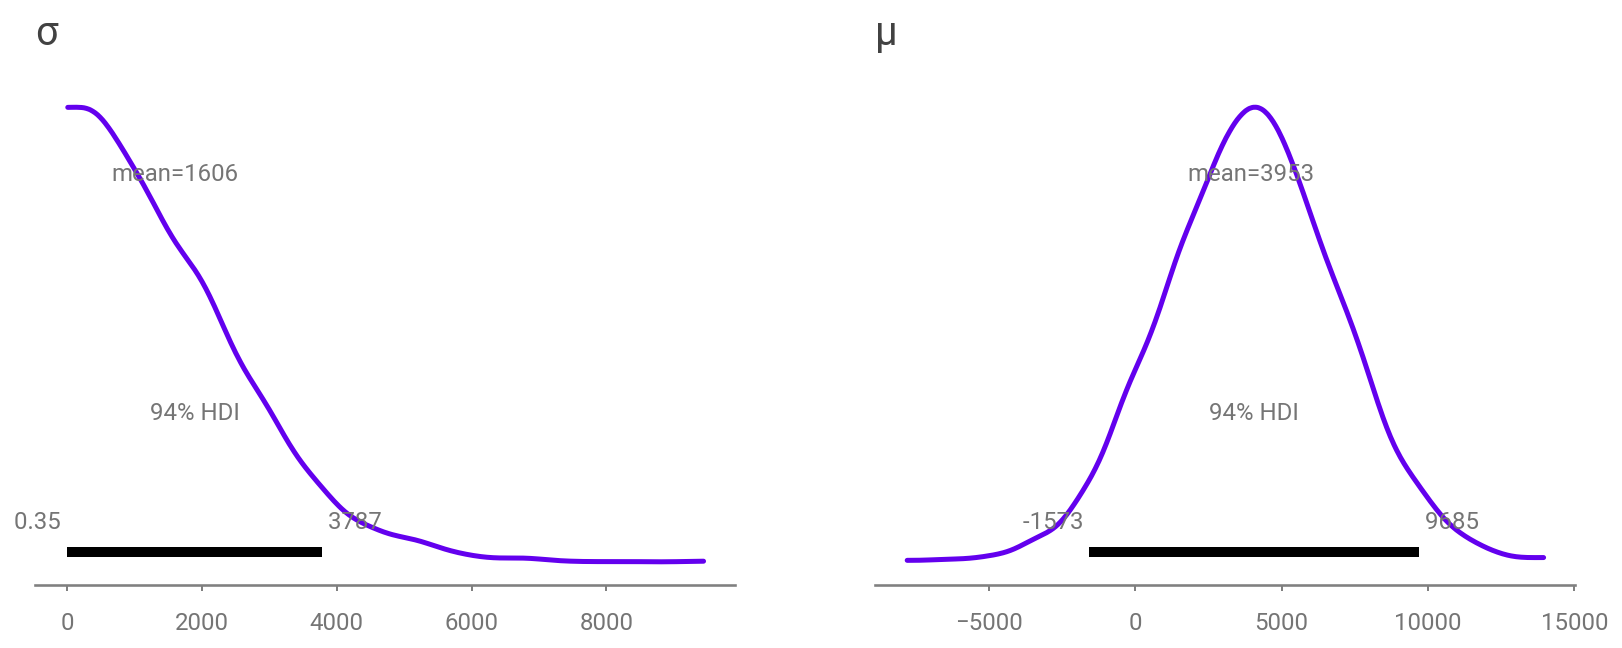

In [31]:
az.plot_posterior(inf_data_adelie_penguin_mass["prior"], var_names=["σ", "μ"]);

In [22]:
az.summary(inf_data_adelie_penguin_mass)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3705.850,38.200,3639.920,3780.905,0.607,0.429,3962.0,2663.0,1.0
σ,462.507,27.502,413.526,515.458,0.440,0.312,3929.0,2726.0,1.0


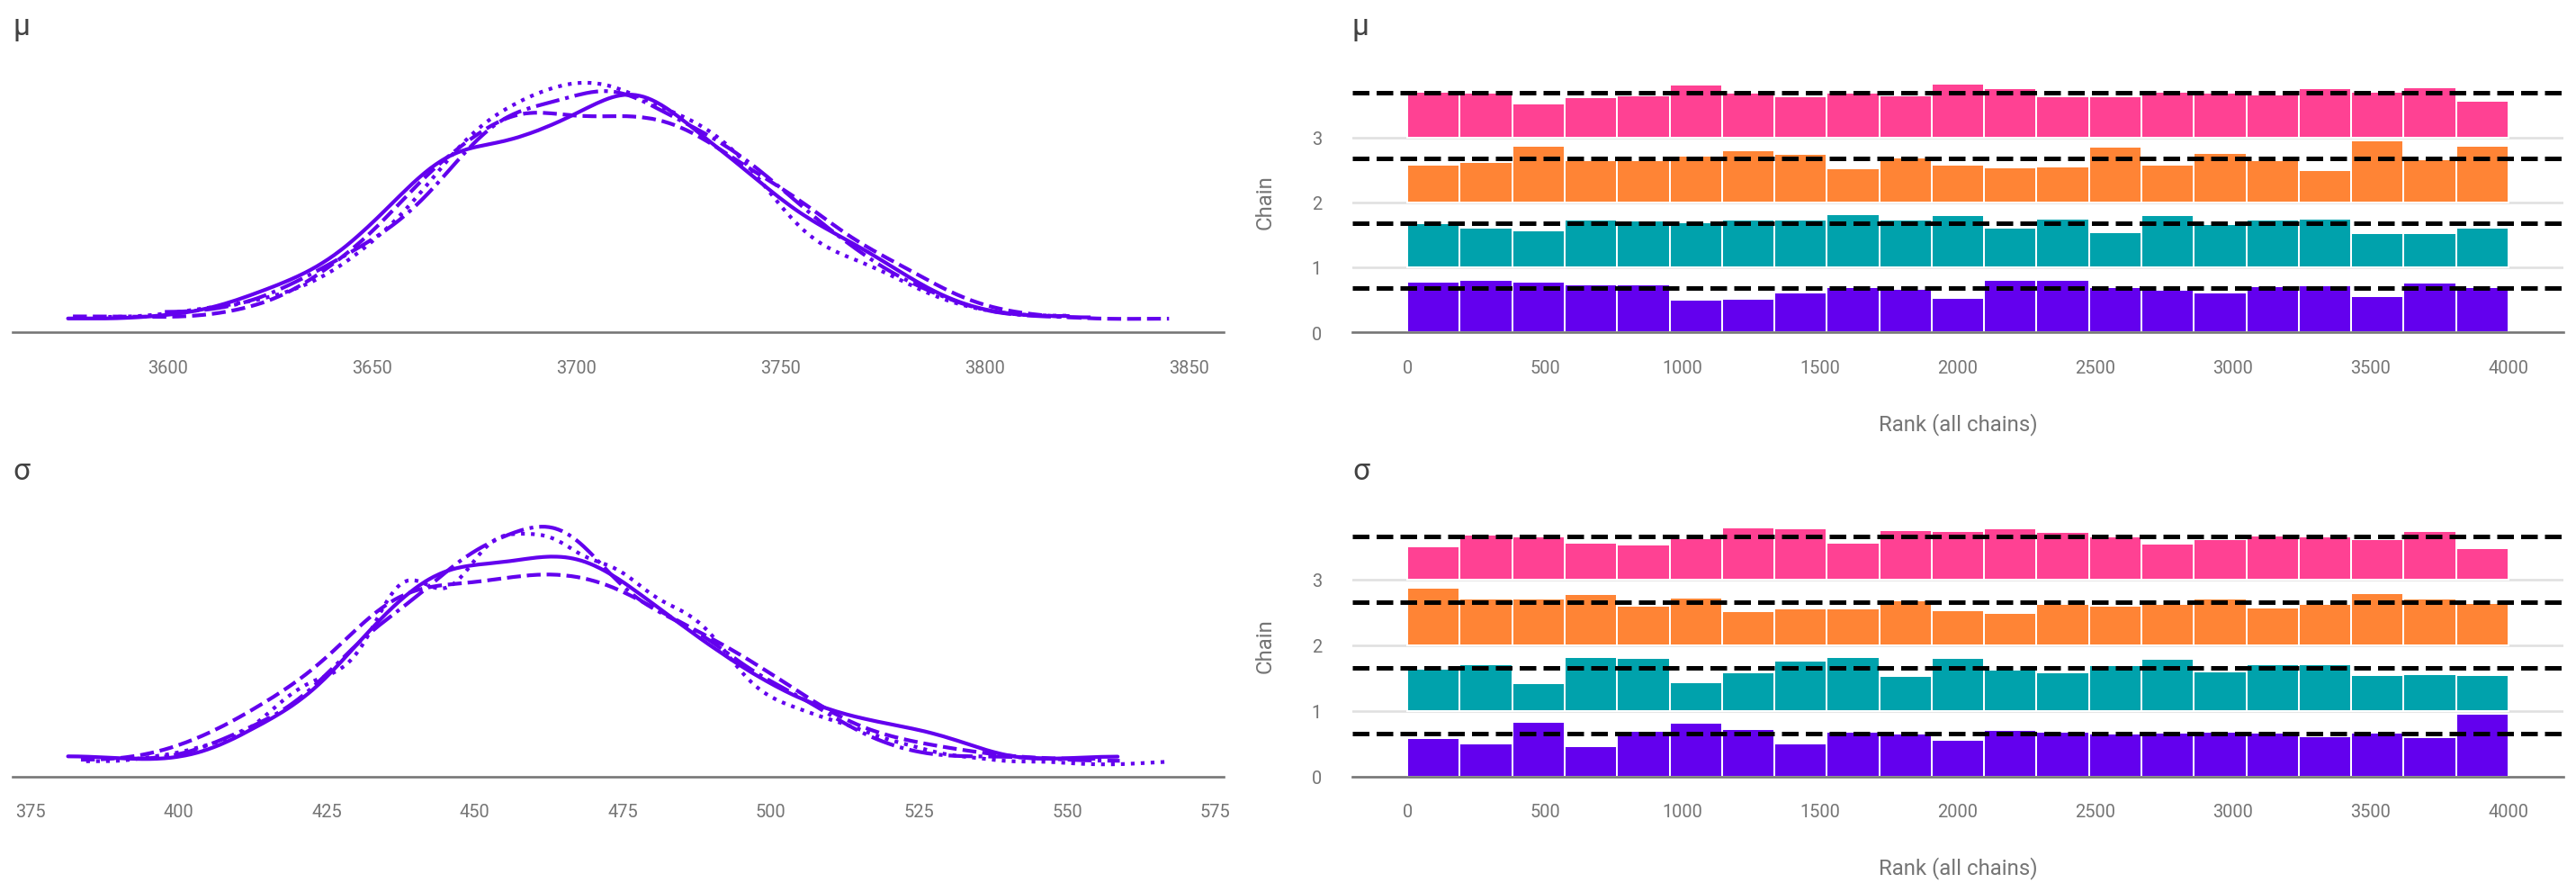

In [32]:
_, axes = plt.subplots(2, 2, figsize=(20, 7))
az.plot_trace(
    inf_data_adelie_penguin_mass, divergences="bottom", kind="rank_bars", axes=axes
)
plt.tight_layout();

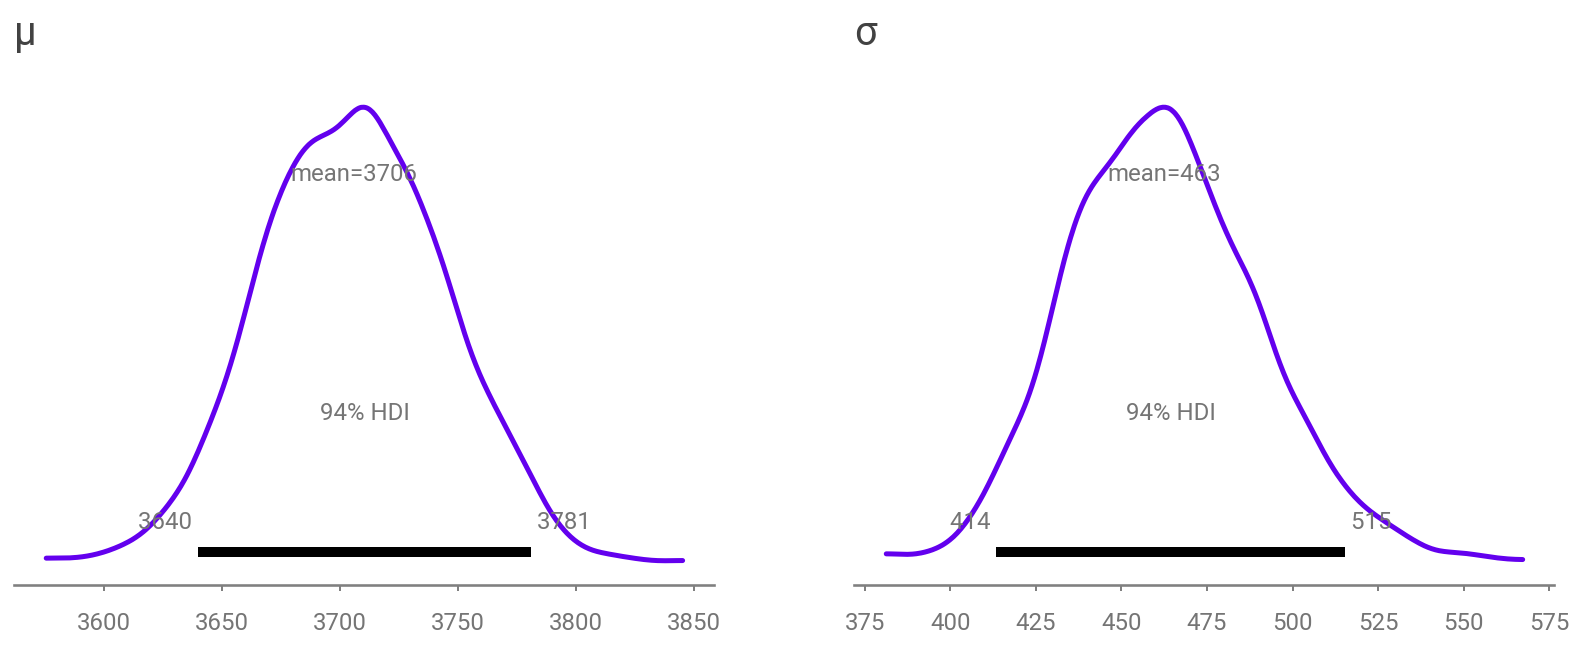

In [33]:
az.plot_posterior(inf_data_adelie_penguin_mass);

In [38]:
all_species = pd.Categorical(penguins["species"])
with pm.Model(
    coords={"species": all_species.categories}
) as model_penguin_mass_all_species:
    σ = pm.HalfStudentT("σ", 100, 2_000, dims="species")
    μ = pm.Normal("μ", 4_000, 3_000, dims="species")
    mass = pm.Normal(
        "mass",
        mu=μ[all_species.codes],
        sigma=σ[all_species.codes],
        observed=penguins["body_mass_g"],
    )
    trace = pm.sample()
    inf_data_model_penguin_mass_all_species = az.from_pymc3(trace=trace)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


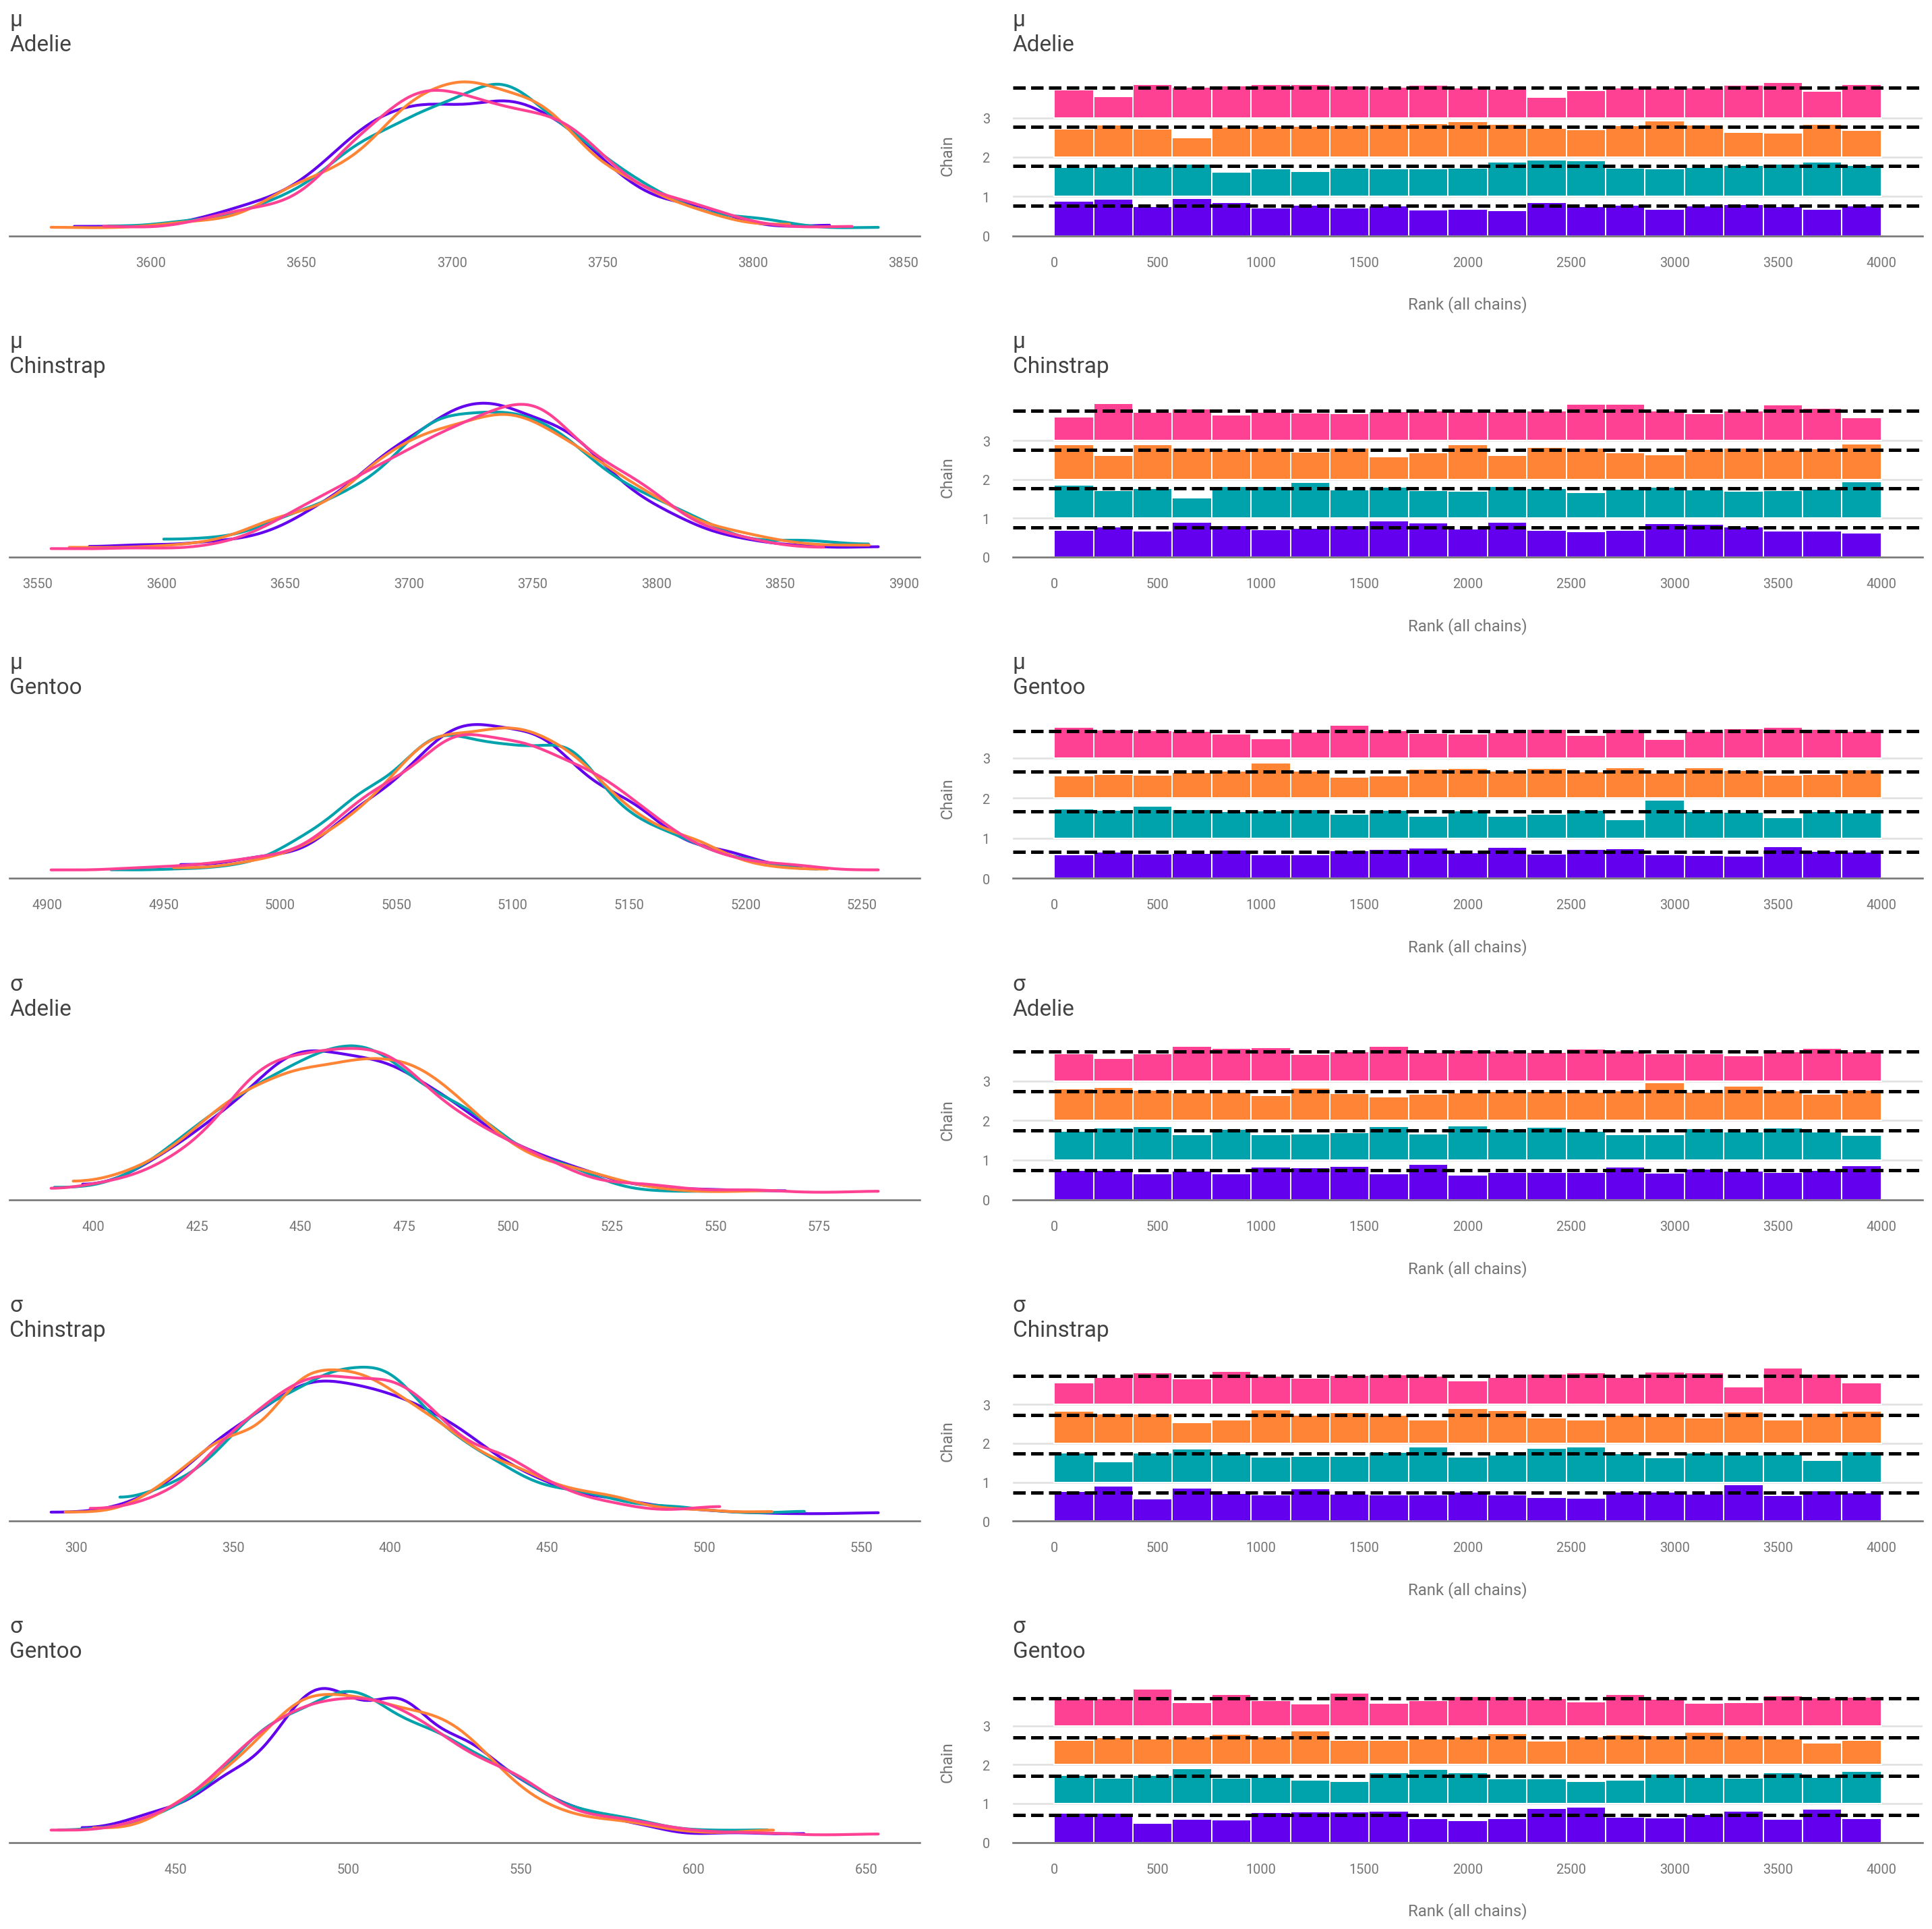

In [46]:
_, axes = plt.subplots(all_species.categories.shape[0] * 2, 2, figsize=(20, 20))
az.plot_trace(
    inf_data_model_penguin_mass_all_species,
    compact=False,
    divergences="bottom",
    kind="rank_bars",
    axes=axes,
)
plt.tight_layout();

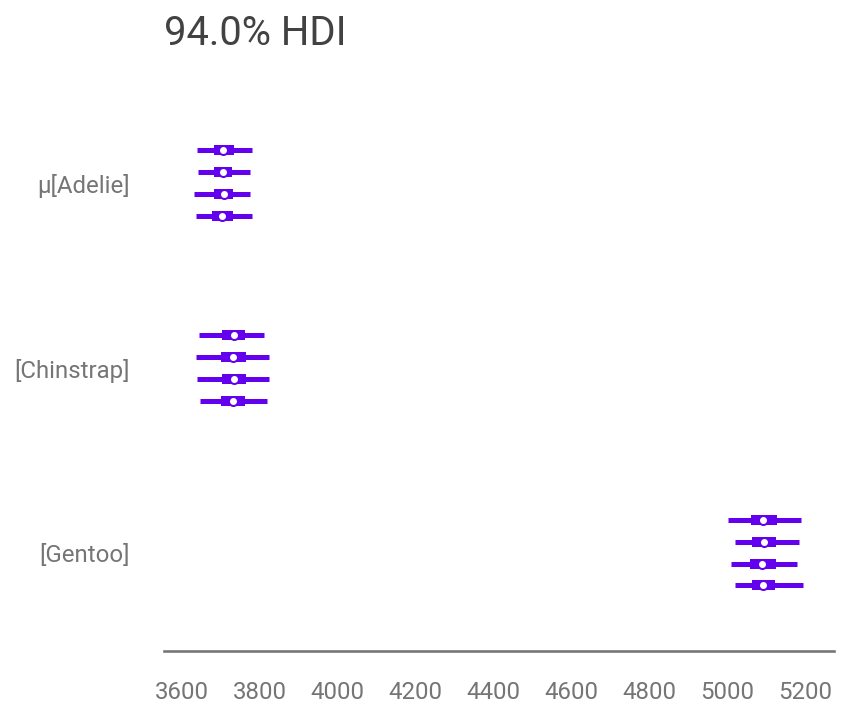

In [48]:
az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["μ"]);

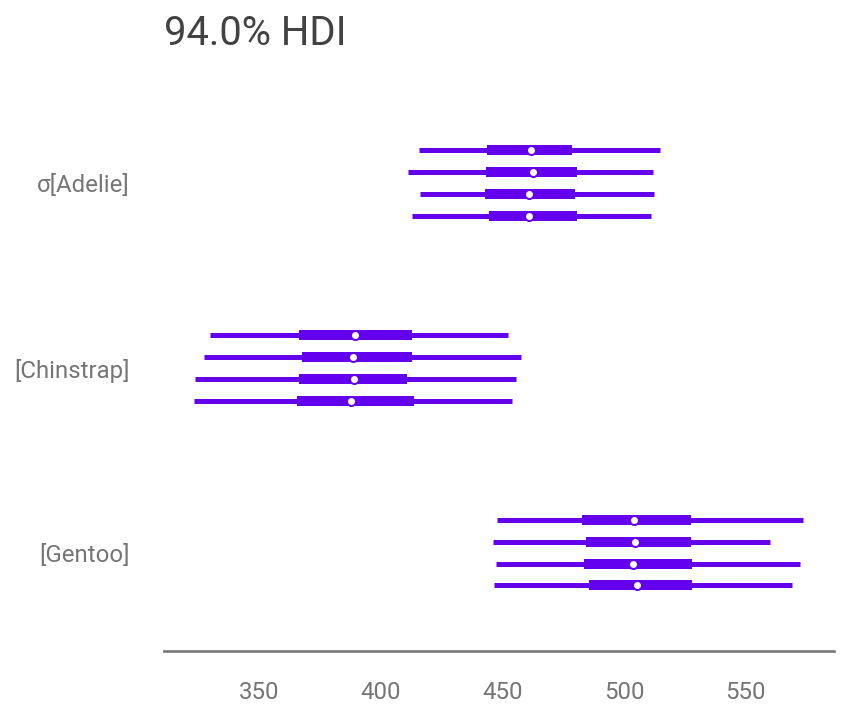

In [51]:
az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["σ"]);

### Comparing two PPLs

In [60]:
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

number_of_species = all_species.categories.shape[0]


@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(
        tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2_000),
            sample_shape=number_of_species,
            name="sigma",
        )
    )
    μ = yield root(
        tfd.Sample(
            tfd.Normal(loc=4_000, scale=3_000),
            sample_shape=number_of_species,
            name="mu",
        )
    )
    mass = yield tfd.Independent(
        tfd.Normal(
            loc=tf.gather(μ, species_idx, axis=-1),
            scale=tf.gather(σ, species_idx, axis=-1),
        ),
        reinterpreted_batch_ndims=1,
        name="mass",
    )

prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

`tfd.Independent` is used to indicate
that the distribution contains multiple copies
that we would like to sum over some axis—specified
by `reinterpreted_batch_ndims` arg—when
computing log-likelihood.

`.sample` can draw conditional samples.

In [61]:
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))

StructTuple(
  sigma=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1, 0.2, 0.3], dtype=float32)>,
  mu=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([10127.934 ,  1436.6582,  3898.2485], dtype=float32)>,
  mass=<tf.Tensor: shape=(333,), dtype=float32, numpy=
    array([10127.897 , 10128.058 , 10127.865 , 10127.869 , 10127.985 ,
           10127.765 , 10127.864 , 10127.876 , 10128.026 , 10127.856 ,
           10127.963 , 10127.851 , 10127.826 , 10127.94  , 10128.083 ,
           10128.066 , 10127.958 , 10127.886 , 10128.069 , 10127.839 ,
           10128.086 , 10127.942 , 10127.742 , 10127.914 , 10128.106 ,
           10127.864 , 10128.013 , 10127.823 , 10128.008 , 10128.019 ,
           10127.909 , 10127.994 , 10127.81  , 10127.816 , 10128.041 ,
           10127.937 , 10127.891 , 10127.929 , 10127.849 , 10127.978 ,
           10127.893 , 10127.906 , 10127.907 , 10128.087 , 10127.836 ,
           10127.888 , 10127.884 , 10127.937 , 10127.925 , 10128.038 ,
           10127.9

In [66]:
target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(
    *x, mass=body_mass_g
)

jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(
    mass=body_mass_g
)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True
)
mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    jd_penguin_mass_all_species,
    n_chains=4,
    num_adaptation_steps=1_000,
    mass=body_mass_g,
)
inf_data_model_penguin_mass_all_species2 = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expected.
        k: np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)

2022-05-09 21:26:17.724463: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [67]:
prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1_000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(value=mcmc_samples)
ppc_samples = samples[-1]
ppc_distribution = dist[-1].distribution
data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# Be careful not to run this code twice during REPL workflow.
inf_data_model_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g},
)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/data/inference_data.py:1372: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


## Linear regression

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \dots + \beta_m X_m \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

or

$$
\mu = \mathbf{X}\boldsymbol{\beta}
$$

 $\mathbf{X}$ is known as the **design matrix**.
 
 ![3D linear regression](images/chapter_3/3d_linear_regression.png)


### Linear penguins

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


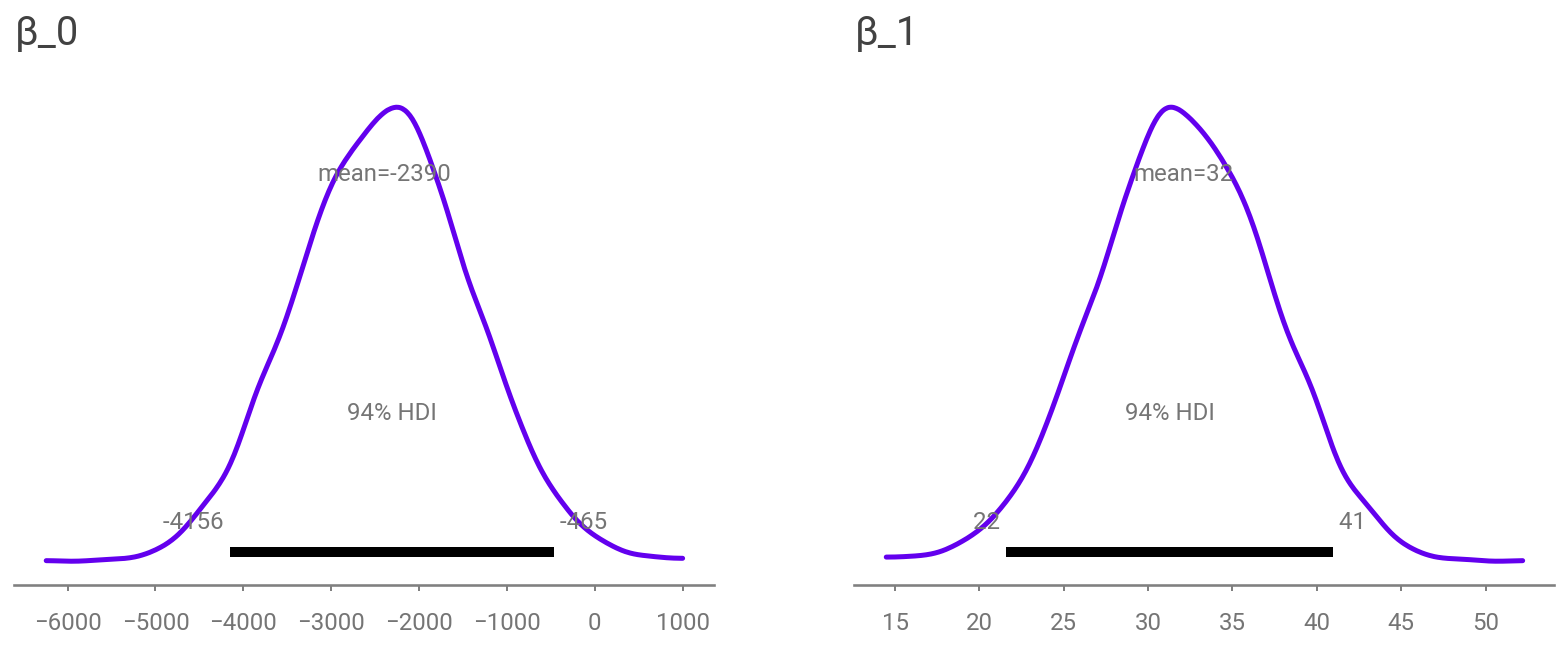

In [137]:
def adelie_mask(penguins_df: DataFrame) -> DataFrame:
    """Create mask to select only Adelie penguins."""
    adelie_penguins_mask = penguins_df["species"] == "Adelie"
    return adelie_penguins_mask

adelie_flipper_length_obs = penguins.loc[
    adelie_mask, "flipper_length_mm"
]

with pm.Model() as model_adelie_flipper_regression:
    adelie_flipper_length = pm.Data(
        "adelie_flipper_length", value=adelie_flipper_length_obs
    )
    σ = pm.HalfStudentT("σ", nu=100, sigma=2_000)
    β_0 = pm.Normal("β_0", mu=0, sigma=4_000)
    β_1 = pm.Normal("β_1", mu=0, sigma=4_000)
    μ = pm.Deterministic("μ", var=β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)

az.plot_posterior(inf_data_adelie_flipper_regression, var_names=["β_0", "β_1"]);

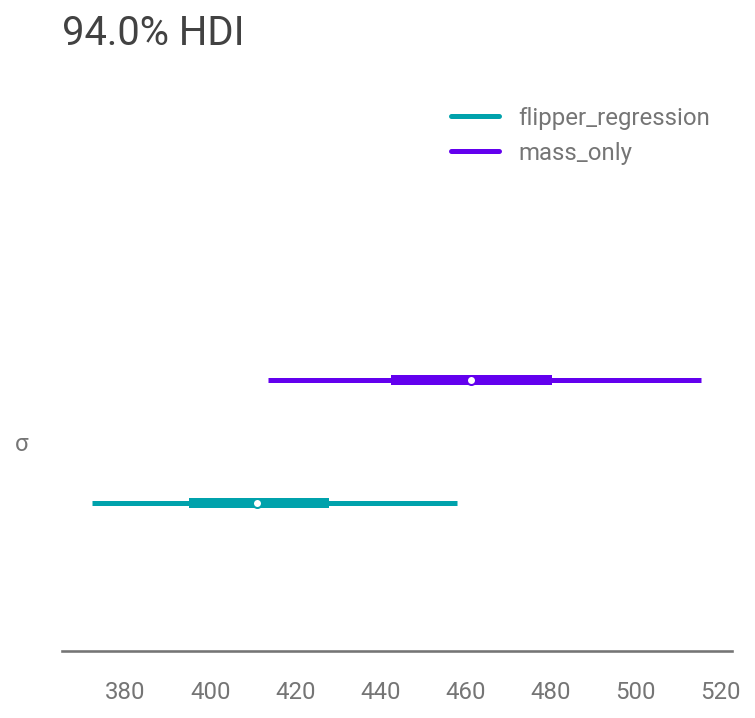

In [74]:
az.plot_forest(
    [inf_data_adelie_penguin_mass, inf_data_adelie_flipper_regression],
    model_names=["mass_only", "flipper_regression"],
    var_names=["σ"],
    combined=True,
);

Incorperating covariate resulted in better predictions
See reduction of $\sigma$.

In [85]:
inf_data_adelie_flipper_regression["posterior"].mean()["β_0"].values.item()

-2364.4180898371164

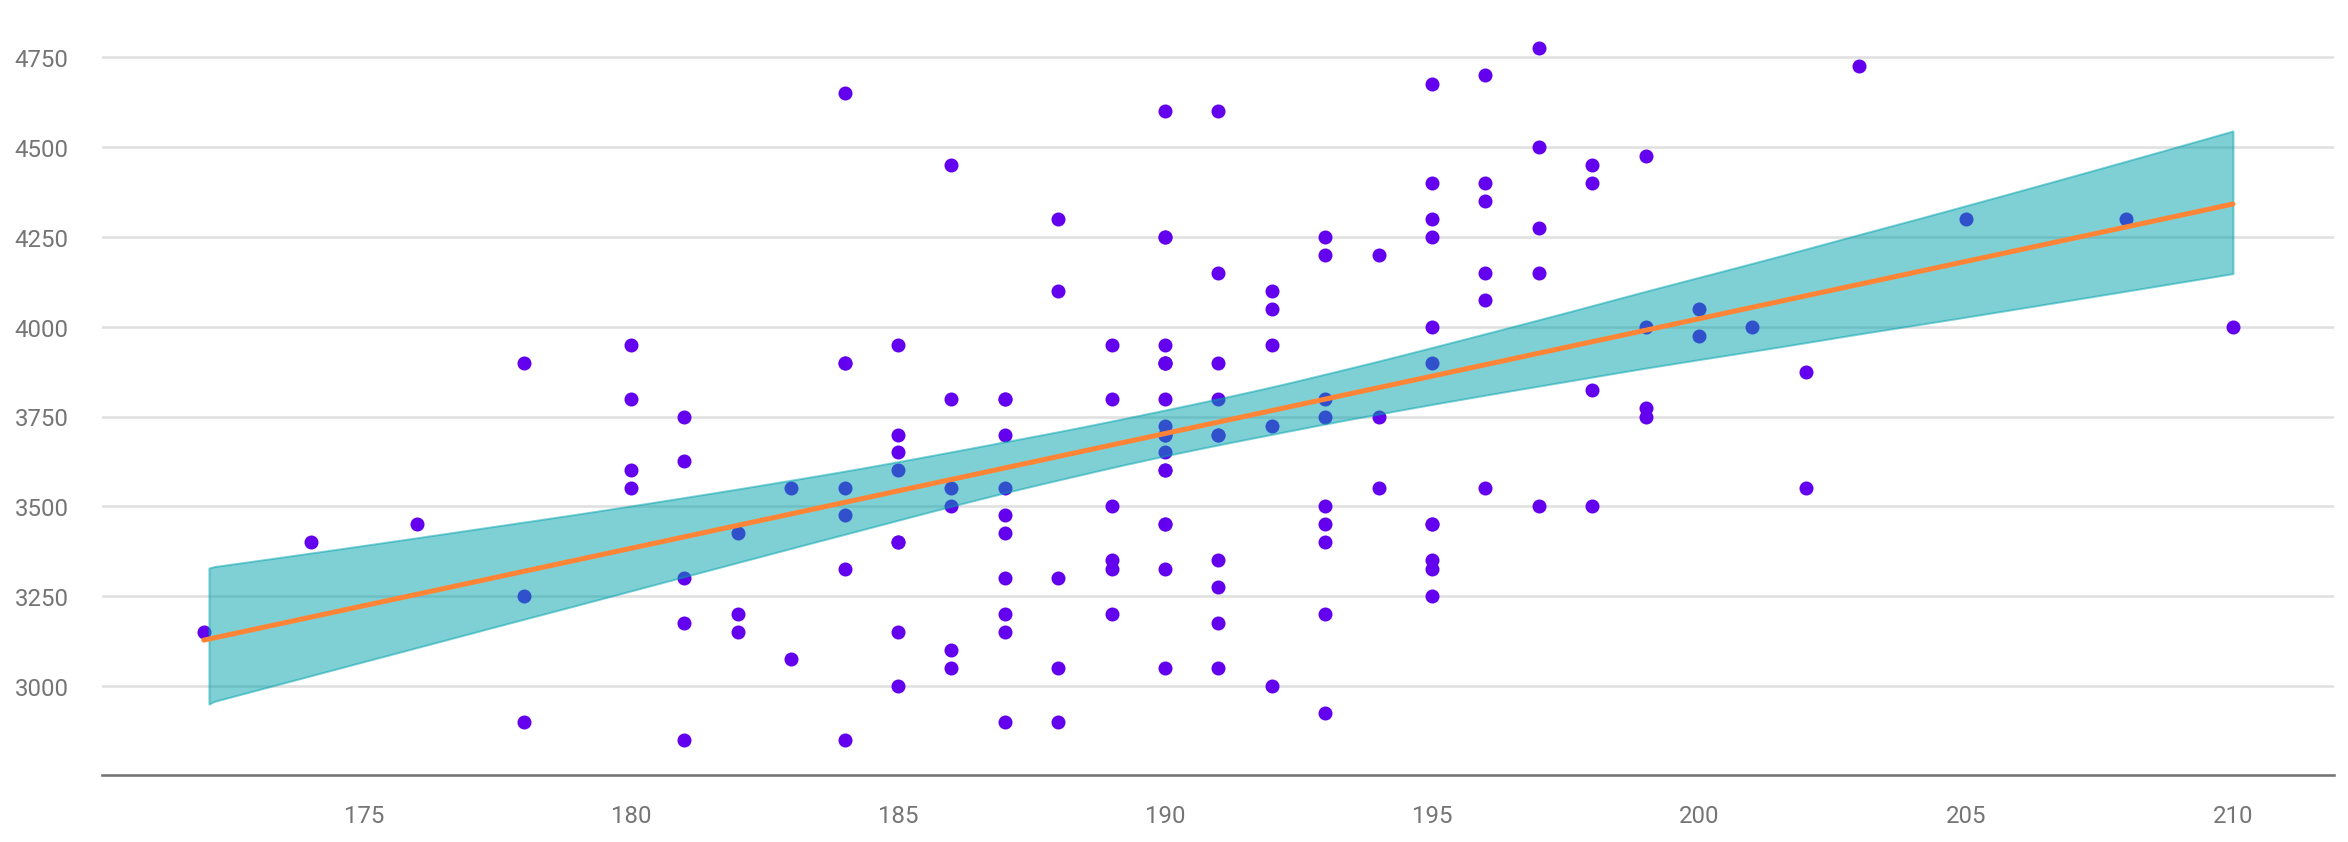

In [88]:
_, ax = plt.subplots(figsize=(20, 7))
alpha_m = inf_data_adelie_flipper_regression["posterior"].mean()["β_0"].values.item()
beta_m = inf_data_adelie_flipper_regression["posterior"].mean()["β_1"].values.item()
flipper_length = np.linspace(
    adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100
)
mass_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, mass_mean, color="C2")
ax.scatter(x=adelie_flipper_length_obs, y=adelie_mass_obs)
az.plot_hdi(
    x=adelie_flipper_length_obs,
    y=inf_data_adelie_flipper_regression["posterior"]["μ"],
    ax=ax,
);

### Predictions

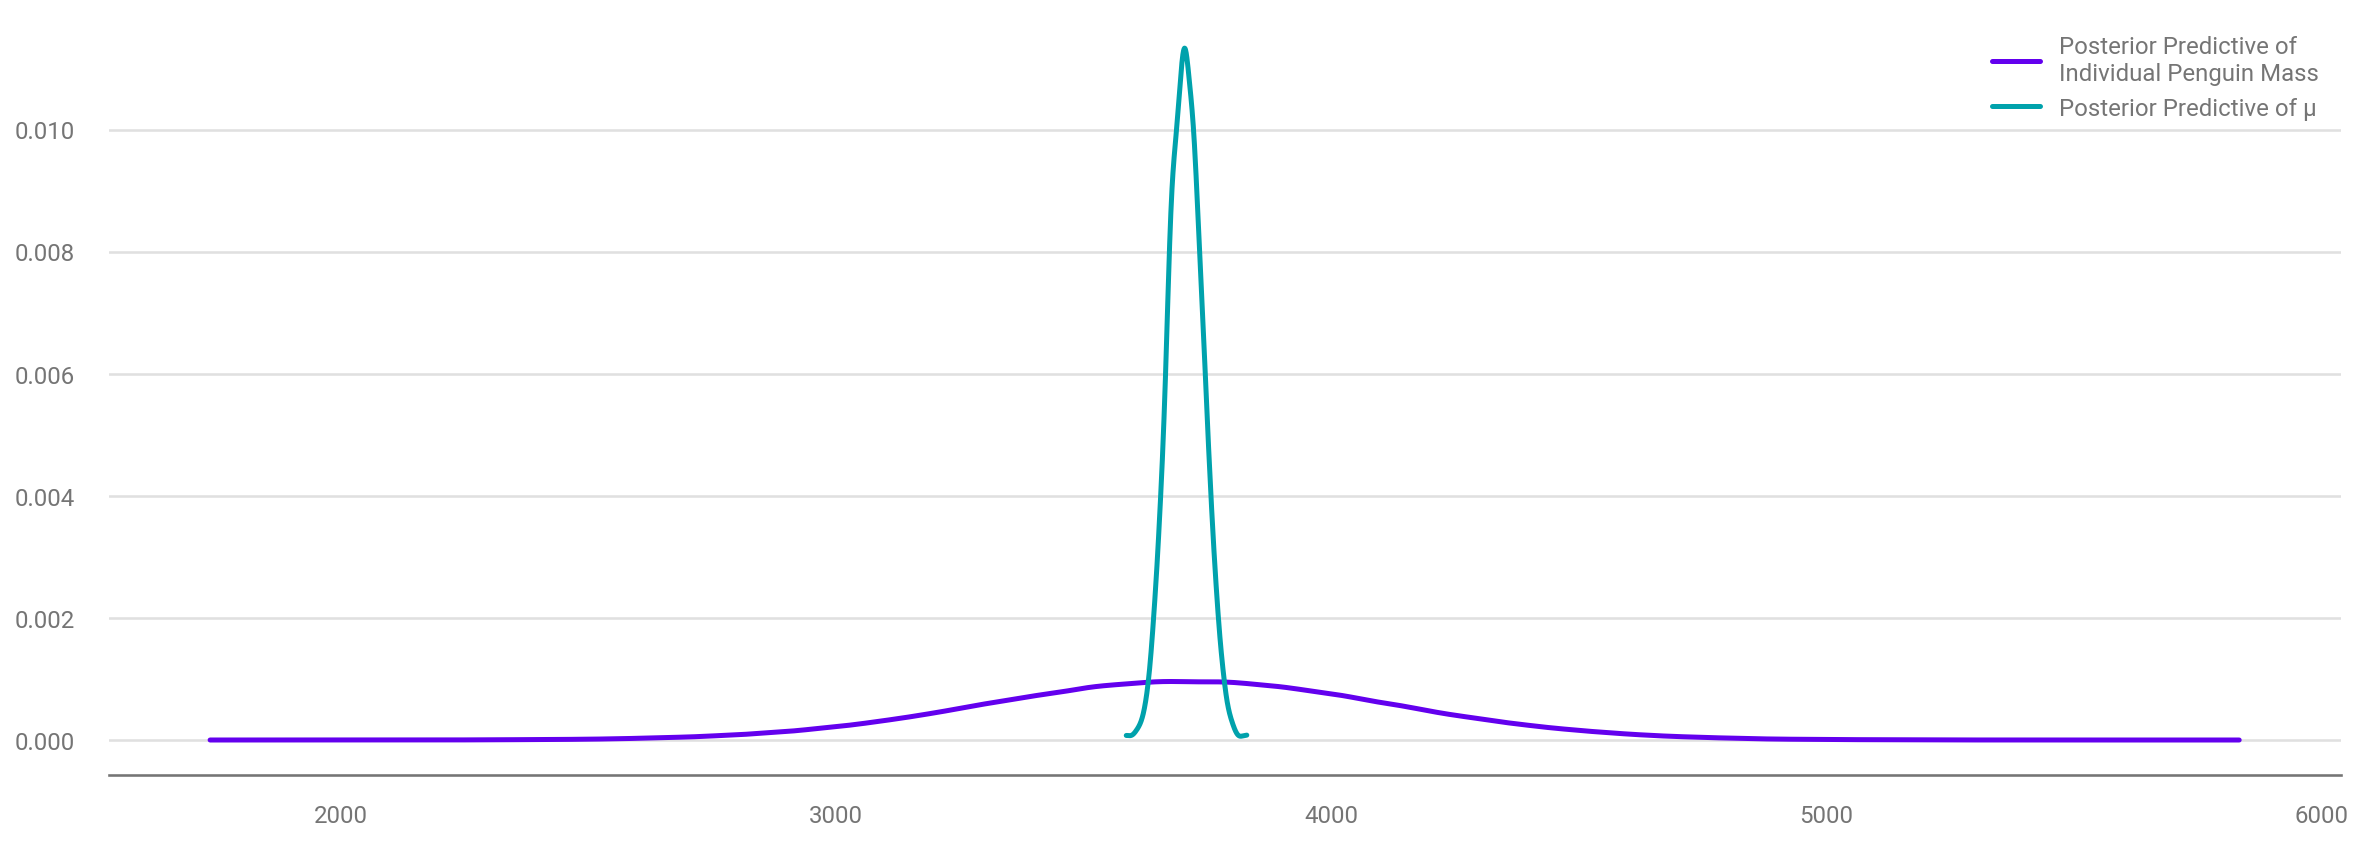

In [97]:
with model_adelie_flipper_regression:
    # Predict mass for panguin with average flipper length
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        inf_data_adelie_flipper_regression["posterior"], var_names=["mass", "μ"]
    )
_, ax = plt.subplots(figsize=(20, 7))
az.plot_dist(
    posterior_predictions["mass"],
    label="Posterior Predictive of \nIndividual Penguin Mass",
)
az.plot_dist(
    posterior_predictions["μ"],
    label="Posterior Predictive of μ",
    color="C1"
)
ax.legend(loc=1)

### Centering

Above,
$\beta_0$ is mostly negative,
and its interpretation is not very useful.
Can center data
by subtrating the mean from it.
This does not affect $\beta_1$,
but now $\beta_0$ is the distribution of the mean masses for penguins with mean flipper length.
Can also subtract the minimum flipper length—which
woudl result in $\beta_0$ being the mass distribution for the smallest oberved flipper length.

2022-05-11 10:14:40.884938: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-11 10:14:40.902662: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-11 10:14:40.917750: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-11 10:14:40.938100: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-11 10:14:41.308854: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-11 10:14:41.314200: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-11 10:14:41.318871: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed 

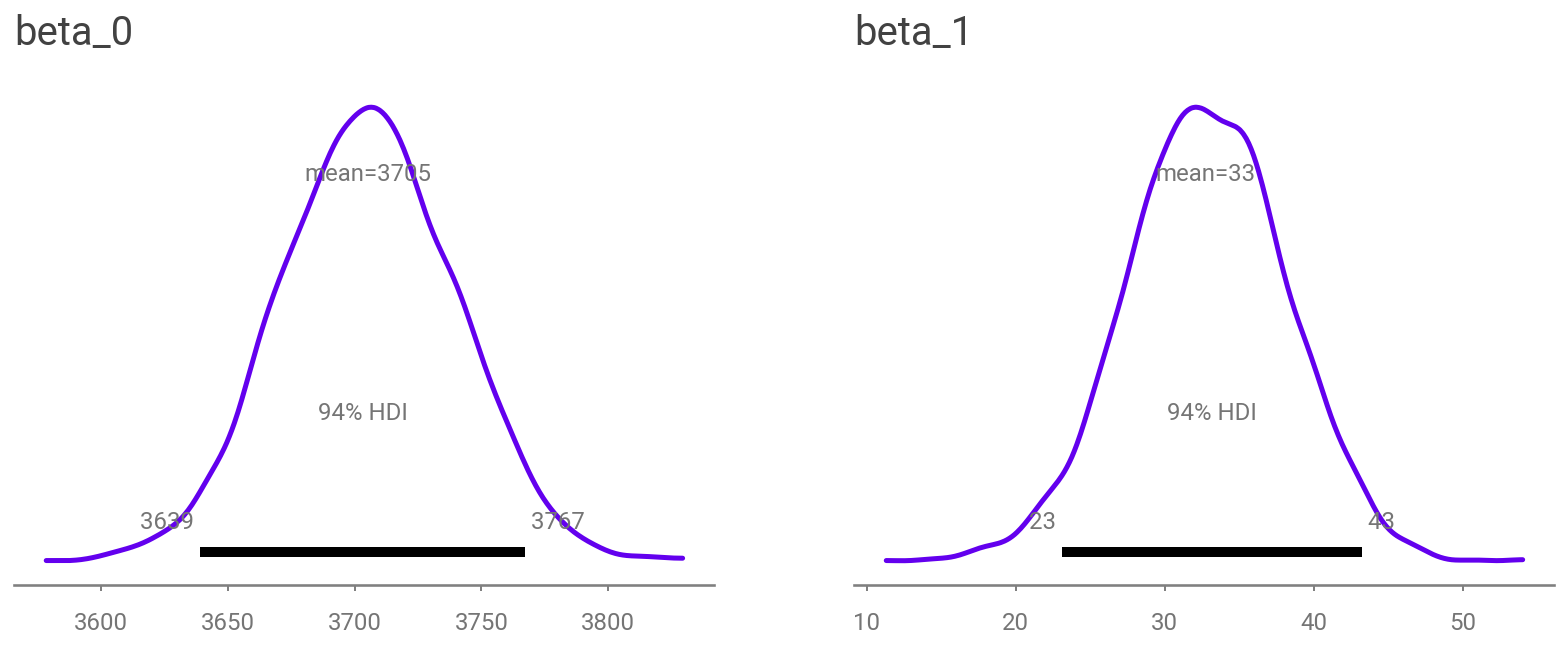

In [106]:
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()


def gen_adelie_flipper_model(adelie_flipper_length):
    adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2_000, name="sigma"))
        β_1 = yield root(tfd.Normal(loc=0, scale=4_000, name="beta_1"))
        β_0 = yield root(tfd.Normal(loc=0, scale=4_000, name="beta_0"))
        μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass",
        )

    return jd_adelie_flipper_regression


jd_adelie_flipper_regression = gen_adelie_flipper_model(adelie_flipper_length_c)
mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    jd_adelie_flipper_regression,
    n_chains=4,
    num_adaptation_steps=1_000,
    mass=tf.constant(adelie_mass_obs, tf.float32),
)

inf_data_adelie_flipper_length_c = az.from_dict(
    posterior={
        key: np.swapaxes(value, 1, 0) for key, value in mcmc_samples._asdict().items()
    },
    sample_stats={
        key: np.swapaxes(sampler_stats[key], 1, 0)
        for key in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names=["beta_0", "beta_1"]);

## Multiple linear regression

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_2, β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


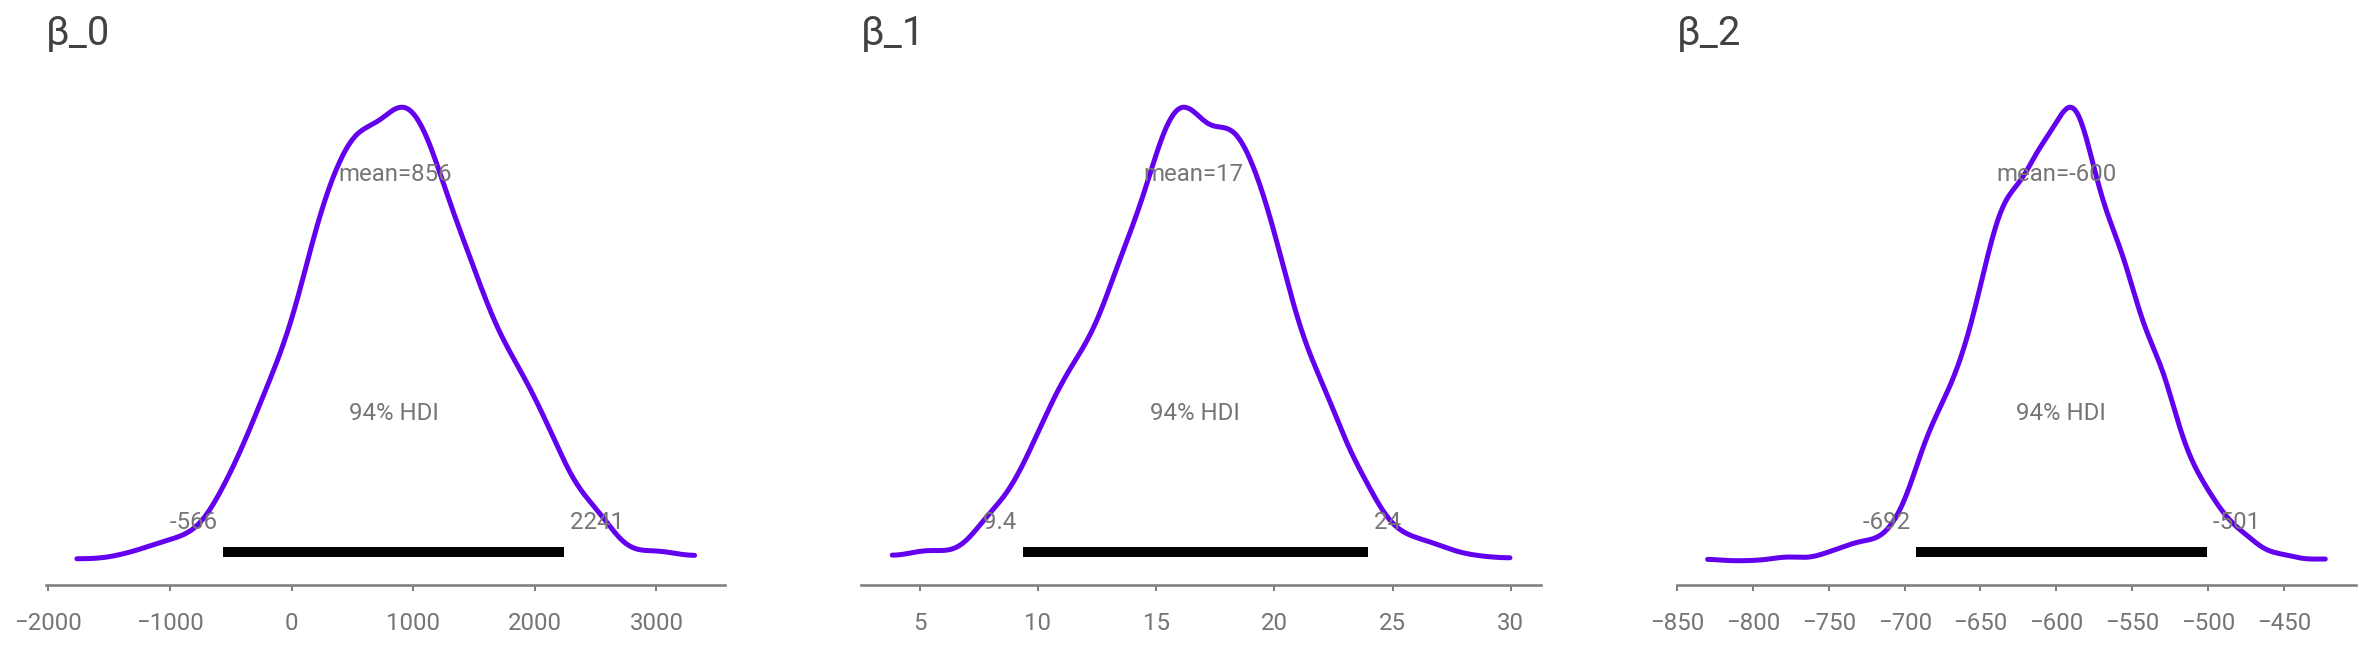

In [128]:
sex_obs = penguins.loc[adelie_mask, "sex"].replace(
    {"male": 0, "female": 1}
)

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", nu=100, sigma=2_000)
    β_0 = pm.Normal("β_0", mu=0, sigma=3_000)
    β_1 = pm.Normal("β_1", mu=0, sigma=3_000)
    β_2 = pm.Normal("β_2", mu=0, sigma=3_000)

    μ = pm.Deterministic("μ", var=β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(
        target_accept=0.9, return_inferencedata=True
    )

az.plot_posterior(inf_data_penguin_mass_categorical, var_names=["β_0", "β_1", "β_2"]);

Bambi version of model.
Priors are automatically assigned.

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, sex, flipper_length_mm, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


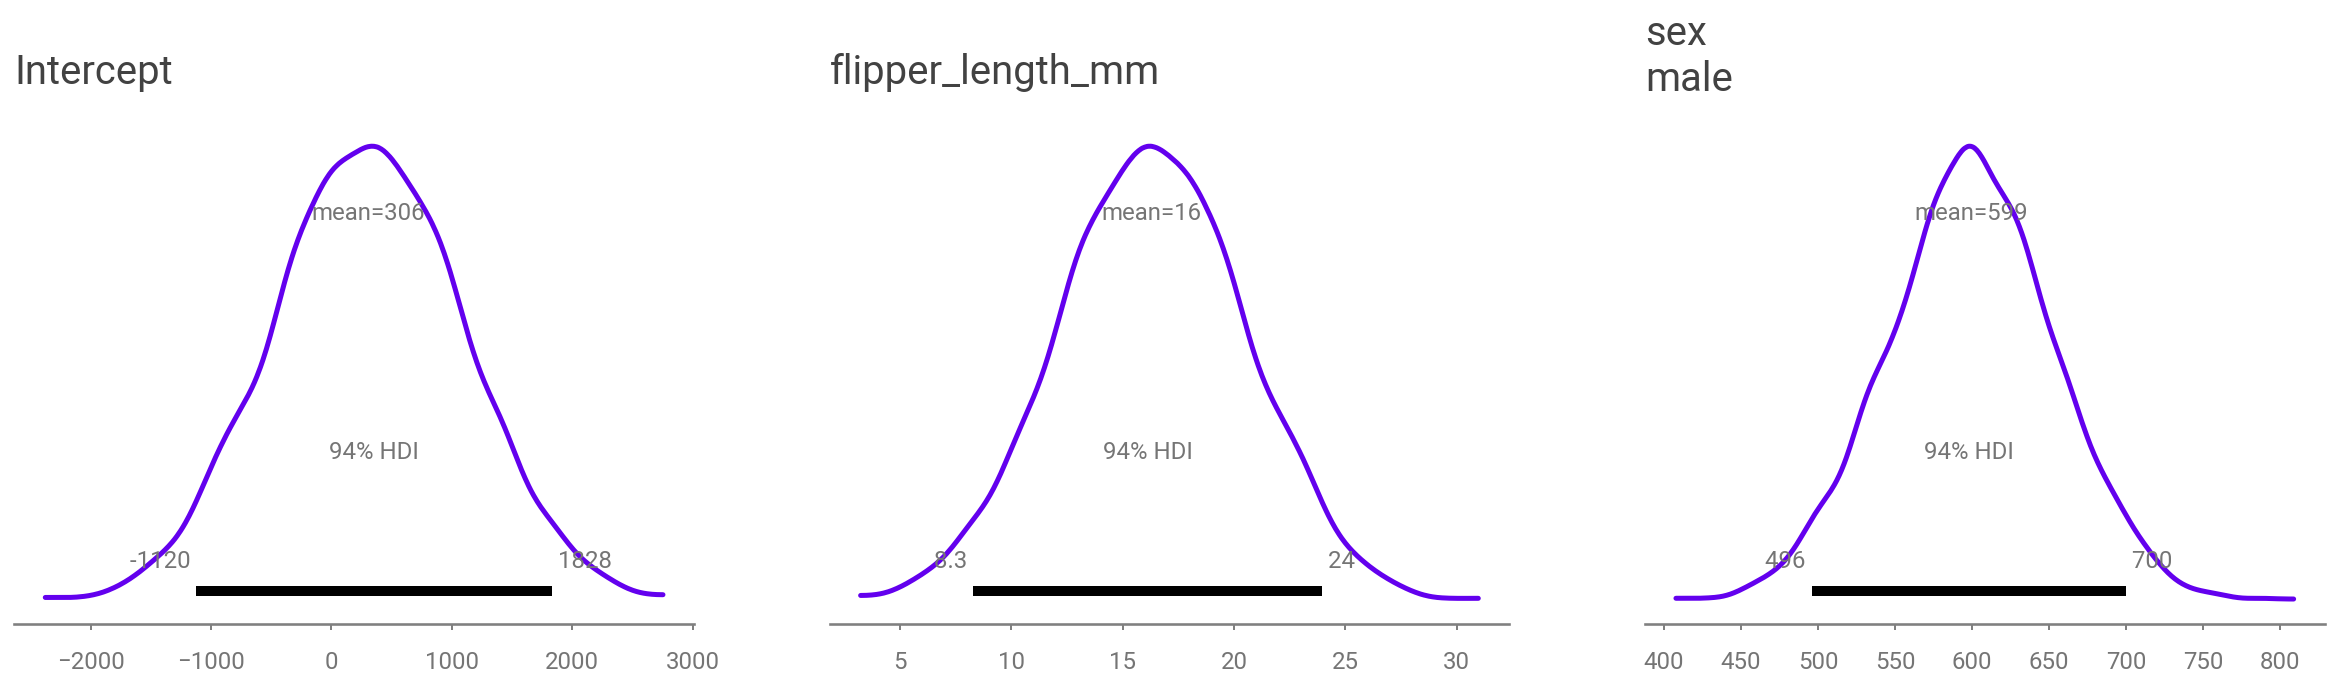

In [129]:
bambi_model = bmb.Model(
    "body_mass_g ~ flipper_length_mm + sex", penguins.loc[adelie_mask]
)
bambi_trace = bambi_model.fit()
az.plot_posterior(bambi_trace, var_names=["Intercept", "flipper_length_mm", "sex"]);

Since male is encoded as 0.
$\beta_2$ estiamtes the difference in mass compared to a female
with the same flipper length.

In [132]:
inf_data_adelie_flipper_regression

Inference data with groups:
	> posterior
	> sample_stats

Standard deviation shows reduced variance.

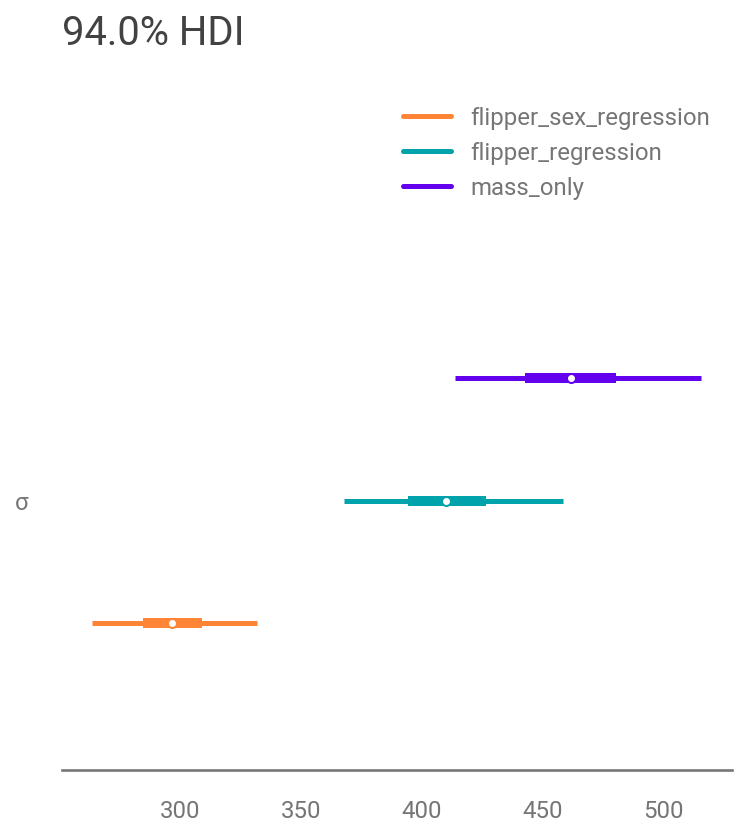

In [139]:
az.plot_forest(
    [
        inf_data_adelie_penguin_mass,
        inf_data_adelie_flipper_regression,
        inf_data_penguin_mass_categorical,
    ],
    model_names=["mass_only", "flipper_regression", "flipper_sex_regression"],
    var_names=["σ"],
    combined=True,
);

### Counterfactuals

We can hold all covariats constant except one
to see how chaniging one covariate changes our expected outcome.
This is a **counterfactual analysys**.

Caveats:

- You can set values that are impossible
- You make the assumption that you can vary covariates independently—ie
  they are not coorelated with each other.

2022-05-13 20:38:06.803538: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-13 20:38:06.833844: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-13 20:38:06.861137: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-13 20:38:06.901076: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-13 20:38:07.417431: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-13 20:38:07.424255: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-05-13 20:38:07.432324: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed 

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'Mass')

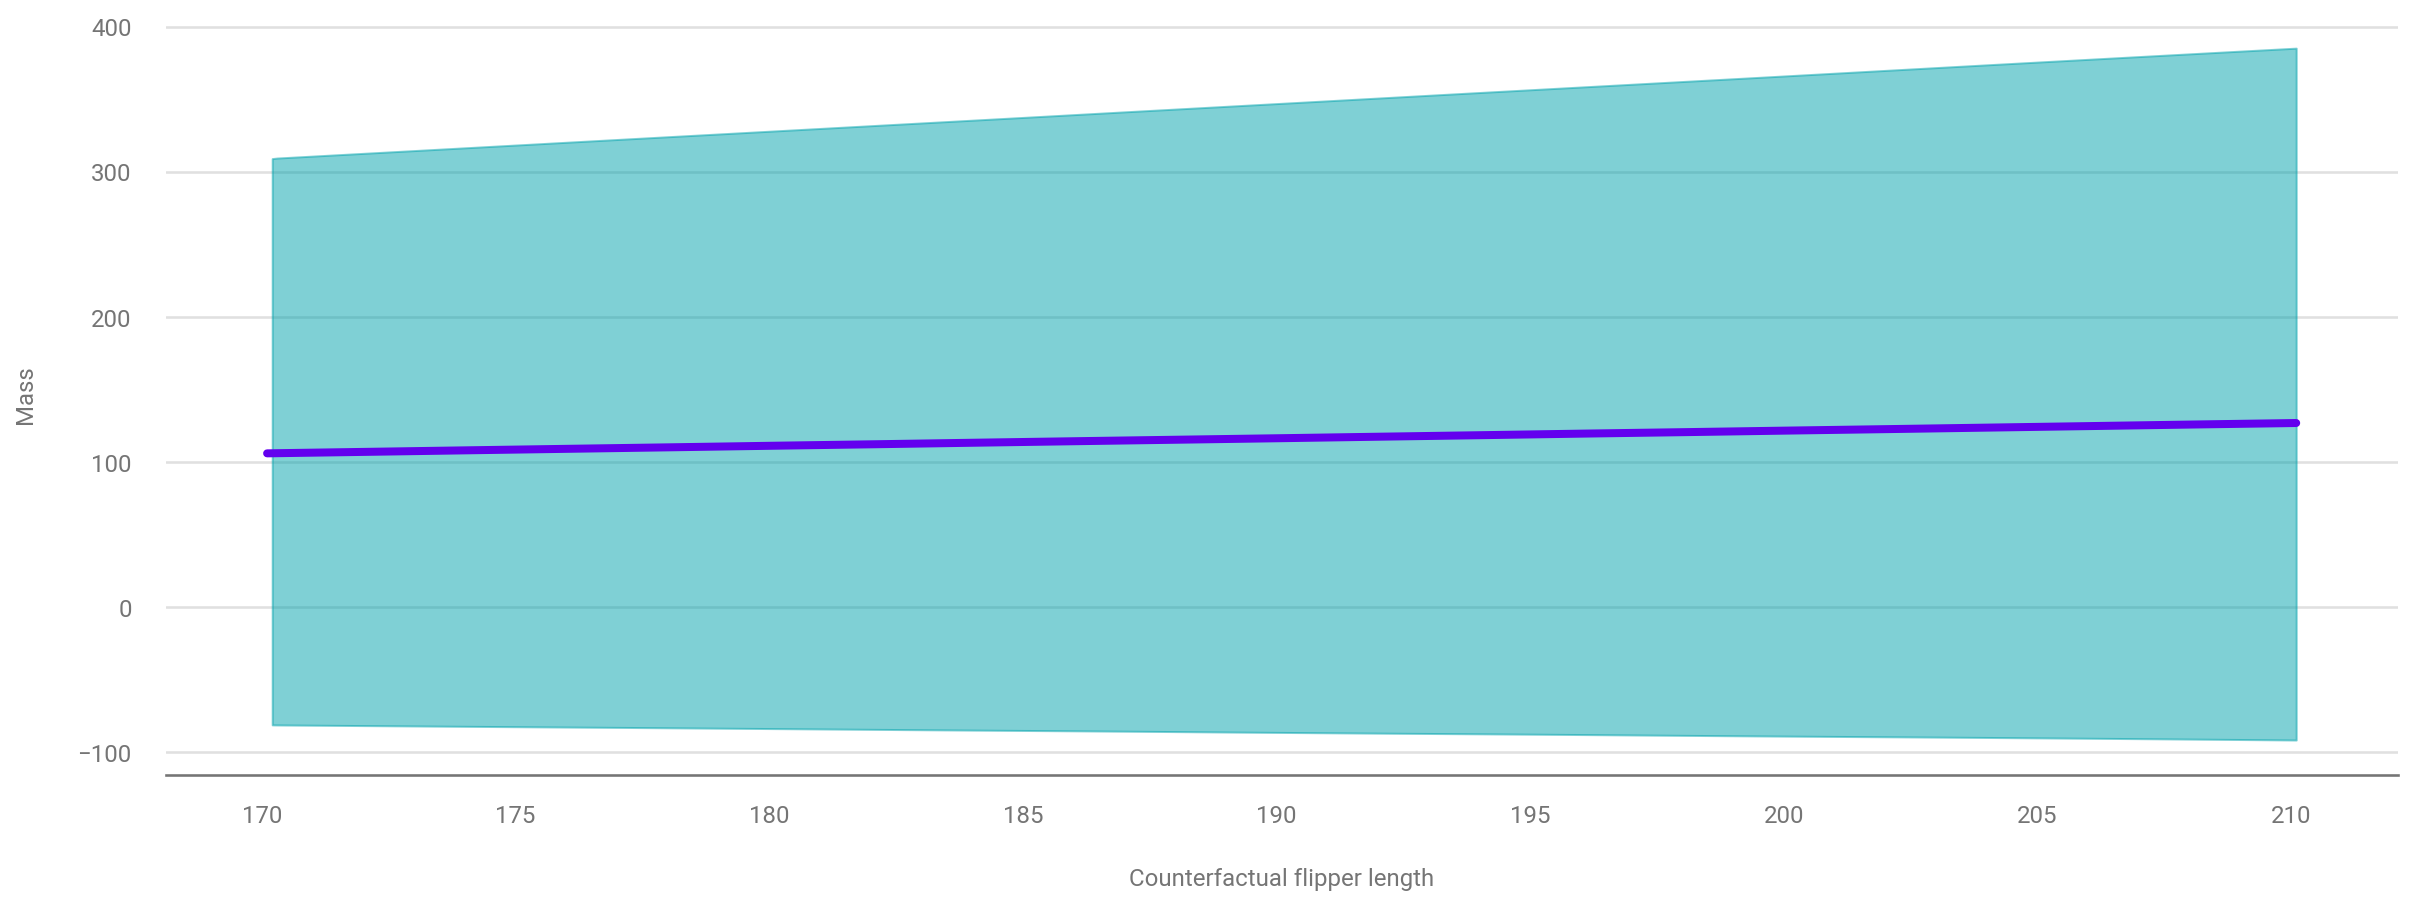

In [146]:
def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length, dtype=tf.float32):
    flipper_length, sex, bill_length = tf.nest.map_structure(
        lambda x: tf.constant(x, dtype), (flipper_length, sex, bill_length)
    )

    @tfd.JointDistributionCoroutine
    def jd_flipper_bill_sex():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
        β_0 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_0"))
        β_1 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_1"))
        β_2 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_2"))
        β_3 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_3"))
        μ = (
            β_0[..., None]
            + β_1[..., None] * flipper_length
            + β_2[..., None] * sex
            + β_3[..., None] * bill_length
        )
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass",
        )

    return jd_flipper_bill_sex


bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
    adelie_flipper_length_obs, sex_obs, bill_length_obs
)

mcmc_samples, sampler_stats = run_mcmc(
    1000,
    jd_flipper_bill_sex,
    n_chains=4,
    num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32),
)

mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
# Counterfactual dimensions is set to 21 to allow us to get the mean exactly
counterfactual_flipper_lengths = np.linspace(
    mean_flipper_length - 20, mean_flipper_length + 20, 21
)
sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = np.ones_like(counterfactual_flipper_lengths) * bill_length_obs.mean()

jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
    counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length
)
ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
estimated_mass = ppc_samples[-1].numpy().reshape(-1, 21)

_, ax = plt.subplots(figsize=(20, 7))
az.plot_hdi(counterfactual_flipper_lengths, estimated_mass, ax=ax)
ax.plot(counterfactual_flipper_lengths, estimated_mass.mean(axis=0), lw=4)
ax.set_xlabel("Counterfactual flipper length")
ax.set_ylabel("Mass")

## Generalized linear models

We may want to use non-normal distributions.
Use **inverse link function** $\phi$:

$$
\mu = \phi(\mathbf{X} \beta) 
$$
$$
Y \sim \Psi (\mu, \theta)
$$

Traditionally **link functions** are applied to left hand side of equation.

### Logistic regression

Used when there are only two possible outcomes,
maps $(-\infty, \infty)$ to $(0,1)$
and uses $logstic$ function as inverse link function.
$logit$ is the link function.

$$
p = \frac{1}{1+e^{-\mathbf{X}\beta}}
$$

![Logistic](images/chapter_3/Logistic.png)


### Classifying penguins

Given mass, sex, and bill length
can you predict species?

If we set decision boundary to 0.5

$$
\begin{split}
0.5 &= logistic(\beta_{0} + \beta_{1}*x) \\
logit(0.5) &= \beta_{0} + \beta_{1}*x \\
0 &= \beta_{0} + \beta_{1}*x \\
x &= -\frac{\beta_{0}}{\beta_{1}} \\
\end{split}
$$

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 28 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<AxesSubplot:>

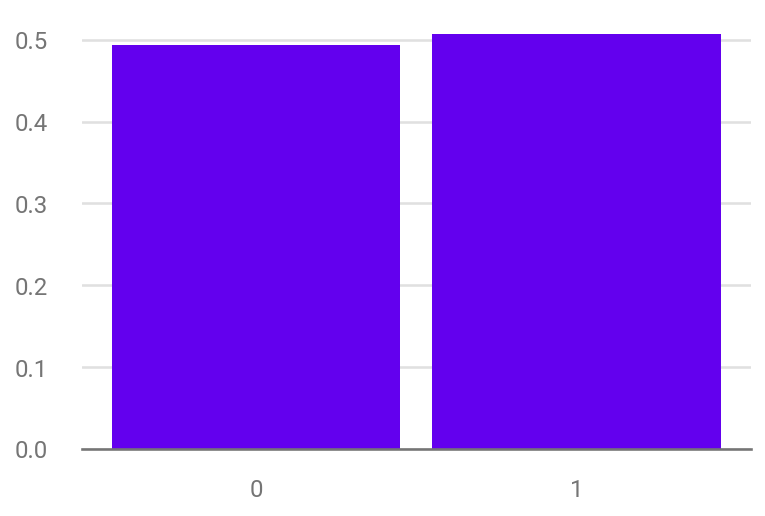

In [175]:
def species_filter(penguins_df: DataFrame) -> DataFrame:
    """Select only Adelie and Chinstrap species."""
    species_filter = penguins_df["species"].isin({"Adelie", "Chinstrap"})
    return species_filter


bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].to_numpy()
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Sigmoid inverse link
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    # Decision boundary where regression = 0
    bd = pm.Deterministic("bd", -β_0 / β_1)
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)  # Not gaussian

    prior_predictive_logistic_penguins_bill_length = pm.sample_prior_predictive(
        samples=10000
    )
    trace_logistic_penguins_bill_length = pm.sample(5000, random_seed=0, chains=2)
    posterior_predictive_logistic_penguins_bill_length = pm.sample_posterior_predictive(
        trace_logistic_penguins_bill_length
    )
    inf_data_logistic_penguins_bill_length = az.from_pymc3(
        prior=prior_predictive_logistic_penguins_bill_length,
        trace=trace_logistic_penguins_bill_length,
        posterior_predictive=posterior_predictive_logistic_penguins_bill_length,
    )

az.plot_dist(prior_predictive_logistic_penguins_bill_length["yl"])

![Logistic_bill_length](images/chapter_3/Logistic_bill_length.png)


In [167]:
az.summary(
    inf_data_logistic_penguins_bill_length,
    var_names=["β_0", "β_1"],
    kind="stats",
)

,mean,sd,hdi_3%,hdi_97%
β_0,-34.701,4.516,-42.536,-26.109
β_1,0.785,0.104,0.593,0.970


In [173]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].to_numpy()

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0 / β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    trace_logistic_penguins_mass = pm.sample(
        5000, random_seed=0, chains=2, target_accept=0.9
    )
    posterior_predictive_logistic_penguins_mass = pm.sample_posterior_predictive(
        trace_logistic_penguins_mass
    )
    inf_data_logistic_penguins_mass = az.from_pymc3(
        trace=trace_logistic_penguins_mass,
        posterior_predictive=posterior_predictive_logistic_penguins_mass,
    )

az.summary(inf_data_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="stats")

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%
β_0,-1.294,1.328,-3.742,1.191
β_1,0.000,0.000,-0.001,0.001


$\beta_1$ is 0
since there is not enough info
to separate the two classes.

![Logistic mass](images/chapter_3/Logistic_mass.png)

In [177]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0, "Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0] / β[2] - β[1] / β[2] * X[:, 1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    trace_logistic_penguins_bill_length_mass = pm.sample(
        5_000, random_seed=0, chains=2, target_accept=0.9
    )
    posterior_predictive_logistic_penguins_bill_length_mass = (
        pm.sample_posterior_predictive(trace_logistic_penguins_bill_length_mass)
    )
    inf_data_logistic_penguins_bill_length_mass = az.from_pymc3(
        trace=trace_logistic_penguins_bill_length_mass,
        posterior_predictive=posterior_predictive_logistic_penguins_bill_length_mass,
    )

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


![Decision Boundary Logistic mass bill length](images/chapter_3/Decision_Boundary_Logistic_mass_bill_length.png)

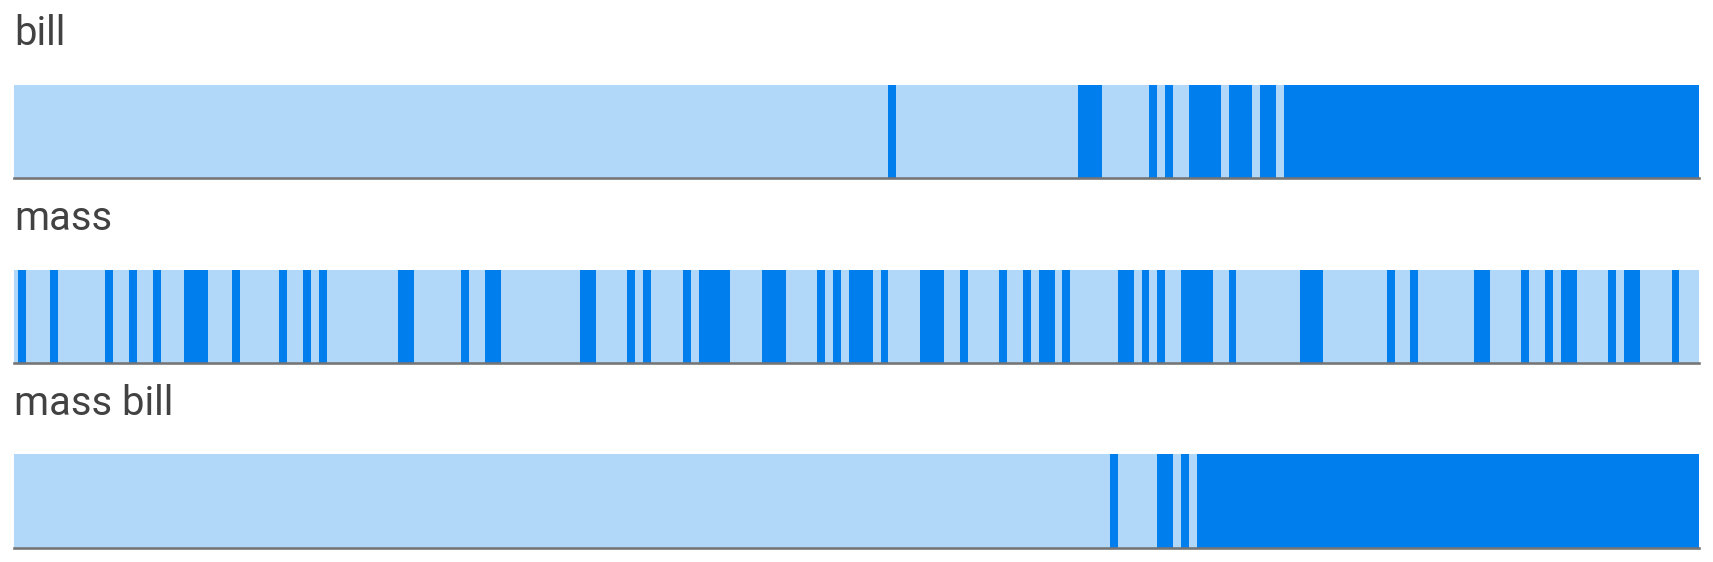

In [180]:
models = {
    "bill": inf_data_logistic_penguins_bill_length,
    "mass": inf_data_logistic_penguins_mass,
    "mass bill": inf_data_logistic_penguins_bill_length_mass,
}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)
plt.tight_layout();

In [181]:
az.compare(
    {
        "mass": inf_data_logistic_penguins_mass,
        "bill": inf_data_logistic_penguins_bill_length,
        "mass_bill": inf_data_logistic_penguins_bill_length_mass,
    }
)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
mass_bill,0,-11.270691,1.614820,0.000000,1.000000e+00,3.119536,0.000000,True,log
bill,1,-27.954787,0.999850,16.684096,8.156081e-11,5.026823,3.960260,False,log
mass,2,-135.744370,1.980294,124.473678,0.000000e+00,5.312905,5.819657,False,log


### Interpreting log odds

In a logisitic regressoin
the slope is the increase in log odds units
when $x$ is incremented by one unit.
Odds are the ratio between the probability of occurrence
and probability of no occurence.

In [182]:
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"]
chinstrap_count = counts["Chinstrap"]
adelie_count / (adelie_count + chinstrap_count)  # Adelie probability

0.6822429906542056

In [183]:
adelie_count / chinstrap_count  # Adelie odds

2.1470588235294117

Odds make interpreting the ratio of one event occurring from another
more straightforward.
For example above
we expect to get 2.14 more times the number of Adelie
than Chinstrap penguins.

The logit
is the natural log of the odds.
$$
\log \left(\frac{p}{1-p} \right) = \boldsymbol{X} \beta
$$

In [190]:
x = 45
β_0 = inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values
β_1 = inf_data_logistic_penguins_bill_length.posterior["β_1"].mean().values
bill_length = 45

val_1 = β_0 + β_1 * bill_length
val_2 = β_0 + β_1 * (bill_length + 1)

(
    f"{special.expit(val_2) - special.expit(val_1):.0%} increase in"
    " class probability when bill length goes from 45 to 56"
)

'15% increase in class probability when bill length goes from 45 to 56'

## Picking priors in regression models

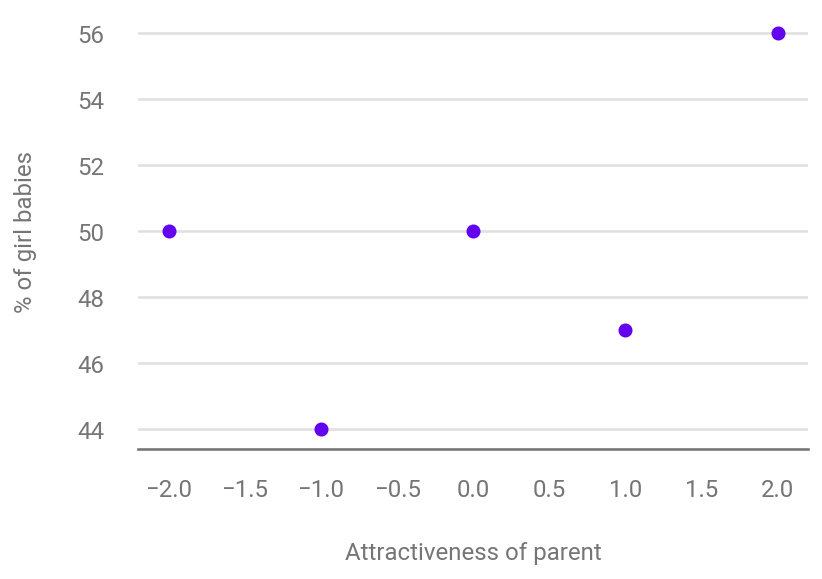

In [193]:
x = np.arange(-2, 3, 1)
y = np.asarray([50, 44, 50, 47, 56])
_, ax = plt.subplots()
ax.scatter(x, y)
ax.set_ylabel("% of girl babies")
ax.set_xlabel("Attractiveness of parent");

In [221]:
with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", 0.5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)
    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    prior_predictive_uninformative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000
    )
    trace_uninformative_prior_sex_ratio = pm.sample()
    inf_data_uninformative_prior_sex_ratio = az.from_pymc3(
        trace=trace_uninformative_prior_sex_ratio,
        prior=prior_predictive_uninformative_prior_sex_ratio,
    )

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/data/inference_data.py:1372: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/lmplot.py:209: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok

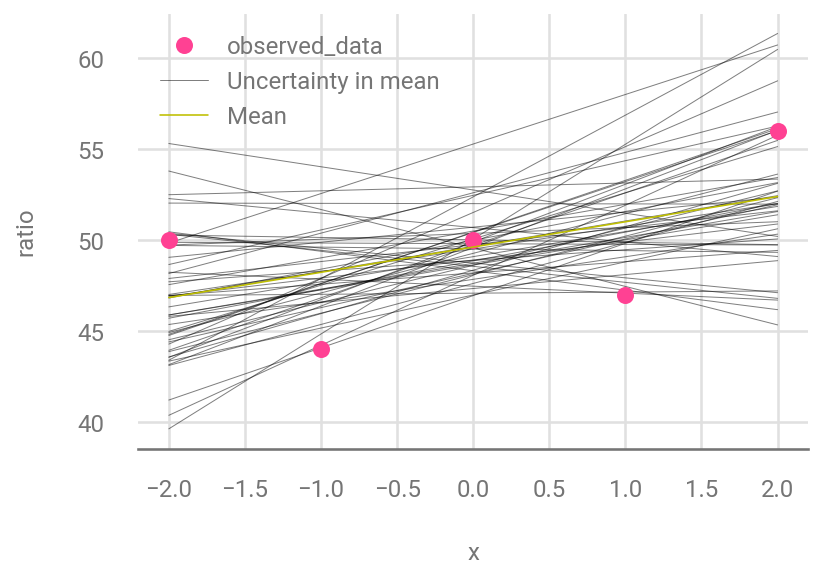

In [222]:
inf_data_uninformative_prior_sex_ratio.add_groups({"constant_data": {"x1": x}})
inf_data_uninformative_prior_sex_ratio["constant_data"]["x"] = x
inf_data_uninformative_prior_sex_ratio["posterior"]["y_model"] = (
    inf_data_uninformative_prior_sex_ratio["posterior"]["β_0"]
    + inf_data_uninformative_prior_sex_ratio["posterior"]["β_1"]
    * inf_data_uninformative_prior_sex_ratio["constant_data"]["x"]
)
az.plot_lm(
    idata=inf_data_uninformative_prior_sex_ratio,
    y="ratio",
    x="x",
    y_model="y_model",
);

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/data/inference_data.py:1372: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/lmplot.py:209: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

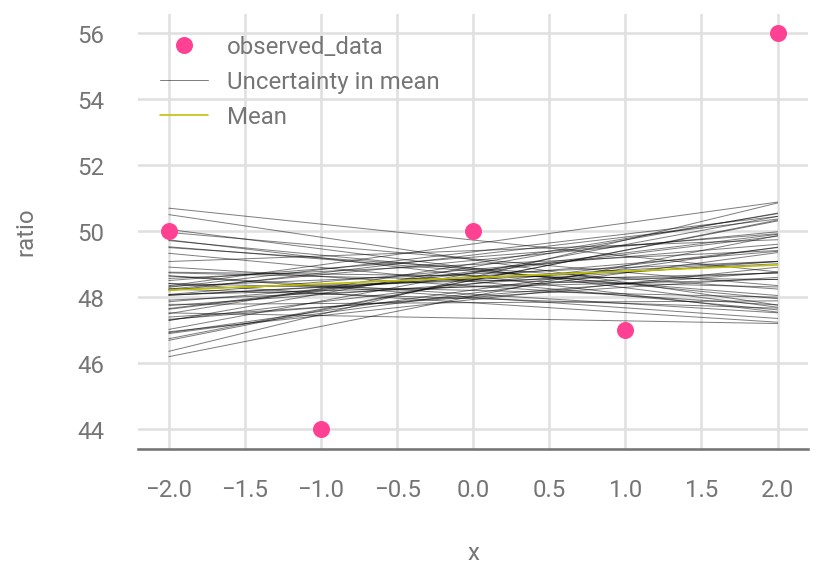

In [223]:
with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", 0.5)

    # Note the now more informative priors
    β_1 = pm.Normal("β_1", 0, 0.5)  # We expect attractiveness to not matter
    β_0 = pm.Normal("β_0", 48.5, 0.5)  # We expect around 50% male/female ratio

    μ = pm.Deterministic("μ", β_0 + β_1 * x)
    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    prior_predictive_informative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000
    )
    trace_informative_prior_sex_ratio = pm.sample()
    inf_data_informative_prior_sex_ratio = az.from_pymc3(
        trace=trace_informative_prior_sex_ratio,
        prior=prior_predictive_informative_prior_sex_ratio,
    )

inf_data_informative_prior_sex_ratio.add_groups({"constant_data": {"x1": x}})
inf_data_informative_prior_sex_ratio["constant_data"]["x"] = x
inf_data_informative_prior_sex_ratio["posterior"]["y_model"] = (
    inf_data_informative_prior_sex_ratio["posterior"]["β_0"]
    + inf_data_informative_prior_sex_ratio["posterior"]["β_1"]
    * inf_data_informative_prior_sex_ratio["constant_data"]["x"]
)
az.plot_lm(
    idata=inf_data_informative_prior_sex_ratio,
    y="ratio",
    x="x",
    y_model="y_model",
);